In [148]:
#imports
import pandas as pd
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from copy import deepcopy

# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer as wn
from nltk.corpus import wordnet
from nltk import pos_tag

import string # 
import re # regex
import itertools # flattening

nltk.download('punkt', quiet=True)
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# tensorflow?

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Viki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Viki/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Viki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Viki/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [132]:
### Data Exploration

In [72]:
df = pd.read_csv('data/all.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,More\nI can't make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312729 entries, 0 to 312728
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             312729 non-null  object
 1   comment_text   312726 non-null  object
 2   toxic          312729 non-null  int64 
 3   severe_toxic   312729 non-null  int64 
 4   obscene        312729 non-null  int64 
 5   threat         312729 non-null  int64 
 6   insult         312729 non-null  int64 
 7   identity_hate  312729 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 19.1+ MB


In [7]:
df.isna().sum()

id               0
comment_text     3
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
# inspecting toxic comments
toxic = dfs.loc[df['toxic'] == 1]
toxic.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
312724,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",1,1,1,1,1,1
312725,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,1,1,1,1,1,1
312726,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",1,1,1,1,1,1
312727,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",1,1,1,1,1,1
312728,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel...",1,1,1,1,1,1


In [9]:
# inspecting a selected comment
print(df.iloc[12]['comment_text'])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [10]:
# checking the toxicity for the selected comment
print(df.iloc[12][df.columns[2:]])

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: object


In [11]:
toxic = df[df['toxic'] == 1]
len(toxic)

110566

In [201]:
toxic = df[df['toxic'] == 0]
len(toxic)

202160

In [192]:
sever = df[df['severe_toxic'] == 1] 
len(sever)

91144

In [13]:
obscene = df[df['obscene'] == 1]
len(obscene)

101322

In [197]:
threat = df[df['threat'] == 1]
len(threat)/len(df)

0.2873793672416109

In [200]:
insult = df[df['insult'] == 1]
len(insult)

100486

In [199]:
hate = df[df['identity_hate'] == 1]
len(hate)

91299

In [198]:
not_threat = df[df['threat'] == 0]
len(not_threat)/len(df)

0.7126206327583892

In [15]:
threat.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,I'm also a sock puppet of this account...SUPRI...,1,0,0,1,0,0
802,02230885017a50c5,"Fuck you, Smith. Please have me notified when ...",1,0,1,1,1,0
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1


### Preprocessing

In [28]:
stopword1 = stopwords.words('english')
    # adding punctuations to stopwords
stopword1 += list(string.punctuation) 

In [44]:
df['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         More\nI can't make any real suggestions on imp...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
312724    . \n i totally agree, this stuff is nothing bu...
312725    == Throw from out field to home plate. == \n\n...
312726    " \n\n == Okinotorishima categories == \n\n I ...
312727    " \n\n == ""One of the founding nations of the...
312728    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 312729, dtype: object

In [70]:
df['comment_text'].isna().sum()

0

In [73]:
df.dropna(inplace = True)

In [107]:
# try this
# def custom_tokenize(text):
#     if not text:
#         print('The text to be tokenized is a None type. Defaulting to blank string.')
#         text = ''
#     return word_tokenize(text)
# df['tokenized_column'] = df.column.apply(custom_tokenize)

In [74]:
# def normalizer(document):
   
#normalized_text = [tok.lower() for tok in word_tokenize(document) if ((tok.isalpha()) & (tok not in stopword1))]
    
#     tagged_text = pos_tag(normalized_text)
#     return normalized_text
    

# def pos_tagger(nltk_tag):
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ
#     elif nltk_tag.startswith('V'):
#         return wordnet.VERB
#     elif nltk_tag.startswith('N'):
#         return wordnet.NOUN
#     elif nltk_tag.startswith('R'):
#         return wordnet.ADV
#     else:         
#         return None

In [75]:
# norm_text = df['comment_text'].apply(normalizer)
# print(type(norm_text))

<class 'pandas.core.series.Series'>


In [ ]:
# norm_text = norm_text.tolist()

In [97]:
# def join(x):
#     return " ".join(x)
# norm_text = [join(x) for x in norm_text]

In [98]:
     
# tagged_text = pos_tag(norm_text)

In [202]:
# wnl = wn()    
# wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), tagged_text)))
# doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

### Modeling

In [112]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        stop_words = stopwords.words('english')
        # adding punctuations to stopwords
        stop_words += list(string.punctuation) 
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = wn()
        stop_words = stopwords.words('english')
        # adding punctuations to stopwords
        stop_words += list(string.punctuation) 
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
            
      # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words))]
        doc_norm = [tok.lower() for tok in doc_norm]
        doc_norm = [tok for tok in doc_norm if tok not in stop_words]
        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [172]:
#targets= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = df['comment_text']
y = df['threat']

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [175]:
proc = TextPreprocessor()

X_train_proc =proc.fit_transform(X_train)
#X_test_proc = proc.transform(X_test)

In [176]:
#X_train_proc[39277]#.tail()

'thanks lot hope much trouble riksdag picture delete absolutely sure freedom information law mean free use least free publication rather modification sale last question create image common name image wikipedia common image delete wikipedia'

In [177]:
#count vectorizer
prc_steps = [('countvec', CountVectorizer(min_df = 0.05, max_df = 0.95))]
preprocess_pipeline = Pipeline(prc_steps)

In [178]:
preprocess_pipeline

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05))])

In [179]:
#type(X_train_proc)

pandas.core.series.Series

In [180]:
X_tr_proc = preprocess_pipeline.fit_transform(X_train_proc)

In [181]:
#type(X_tr_proc)

scipy.sparse._csr.csr_matrix

In [182]:
feature_names = preprocess_pipeline[
     'countvec'].get_feature_names_out()

pd.DataFrame(X_tr_proc.toarray(), columns = feature_names)

,add,also,article,change,comment,delete,edit,even,find,first,...,time,try,use,user,want,way,well,wikipedia,work,write
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218903,0,1,1,0,0,1,0,0,0,0,...,3,0,0,0,0,0,0,0,0,2
218904,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
218905,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
218906,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [183]:
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

0    0.712011
1    0.287989
Name: threat, dtype: float64

In [ ]:
# class1_bow_mat = bow_mat[bow_mat['target'] == 1].drop(columns = ['target'])

# # class 1 token probabilities:
# N_tok_1 = class1_bow_mat.sum(axis = 0) # token occurence
# N_1 =  class1_bow_mat.values.sum() # number of tokens

# # get probabilities for each token: class 1
# proba_c1 = N_tok_1/N_1

# proba_c1.sort_values(ascending = False)[0:10]

In [184]:
y_train

51768     0
235541    0
161086    1
141851    0
263963    1
         ..
199659    1
141286    0
15907     0
92910     0
66692     0
Name: threat, Length: 218908, dtype: int64

In [185]:
mod_pipe = deepcopy(preprocess_pipeline)
mod_pipe.steps.append(('multinb', MultinomialNB()))
mod_pipe.steps

[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [186]:
mod_pipe.fit(X_train_proc, y_train)

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [187]:
transformed_test = proc.transform(X_test)

y_pred = mod_pipe.predict(transformed_test) # automatically applies transforms and predicts on test

In [188]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83     66990
           1       0.30      0.01      0.03     26828

    accuracy                           0.71     93818
   macro avg       0.51      0.50      0.43     93818
weighted avg       0.60      0.71      0.60     93818



In [189]:
roc_auc_score(y_test, y_pred)

0.5005402875745493

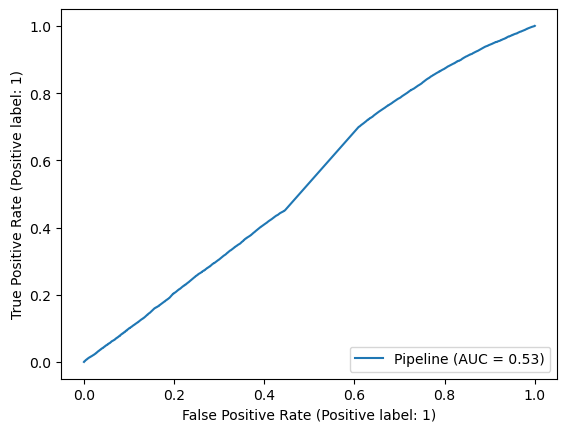

In [190]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(mod_pipe, transformed_test, y_test)

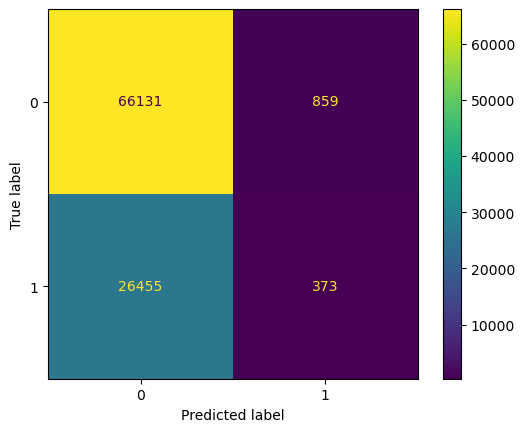

In [191]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(mod_pipe, transformed_test, y_test);

In [ ]:
### Model 2

In [203]:
# try SMOTE to address the imbalance
